## Week 13 Workshop

In this week we will work with chemical language models. First we will train a simple classifier that can detect different molecule types based on the molecules' SMILES strings. Then we will train a predictor for membrane permeation of cyclic peptides, as in [Feller & Wilke (2025).](https://doi.org/10.1021/acs.jcim.4c01441) 

First, we import all the dependencies.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from rdkit import Chem
import torch
from torch.utils.data import DataLoader
import plotnine as pln

from transformers import AutoModel, AutoTokenizer

from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr

import os
# don't run tokenizer in parallel
os.environ['TOKENIZERS_PARALLELISM'] = "false"

## Part 1: Predict molecule types

We start with a simple project where we predict different molecule types (small molecule, lipid, peptide) from the SMILES string. We will be using an updated Chemical Language Model (CLM) trained by Aaron Feller. The paper describing this model is not yet published, but the model is available on HuggingFace. The model is called PeptideMTR for Multi-Task Regression. This refers to how the model was trained. For our purposes here, it is simply a CLM we can use to calculate embeddings.

In [2]:
model = AutoModel.from_pretrained("aaronfeller/PeptideMTR_sm", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("aaronfeller/PeptideMTR_sm")

device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
model.to(device)

Skipping import of cpp extensions due to incompatible torch version 2.9.1 for torchao version 0.14.1             Please see https://github.com/pytorch/ao/issues/2919 for more info
W1117 17:03:52.183000 24450 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


MLM_model(
  (model): MLM_core(
    (embed): Embedding(405, 512)
    (transformer): TransformerStack(
      (blocks): ModuleList(
        (0-13): 14 x UnifiedTransformerBlock(
          (attn_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (attn): MultiHeadAttention(
            (qkv_proj): Linear(in_features=512, out_features=1536, bias=False)
            (rotary): RotaryPositionalEmbeddings()
            (out_proj): Linear(in_features=512, out_features=512, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (ffn_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (ffn): SwiGLU(
            (linear1): Linear(in_features=512, out_features=1536, bias=True)
            (linear2): Linear(in_features=768, out_features=512, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (sequence_head): Line

Next we load the data.

In [3]:
df_mol_types = pd.read_csv("data/molecule-types.csv")
df_mol_types

,id,smiles,category
0,LMPR01070696,C1C(C)(C)C(/C=C/C(/C)=C/C=C/C(/C)=C/C=C/C=C(\C...,lipid
1,LMSP0506AU03,[C@](CO[C@@H]1O[C@H](CO)[C@@H](O[C@@H]2O[C@H](...,lipid
2,LMGP05040001,O(CC[C@H](C)CCC[C@H](C)CCC[C@H](C)CCCC(C)C)C[C...,lipid
3,LMST01010246,[C@@]12([H])[C@H](O)C[C@@]3([H])[C@@H](C(=O)O)...,lipid
4,LMPK12111347,C1(O[C@H]2[C@H](O[C@H]3[C@H](O)[C@H](O)[C@H](O...,lipid
...,...,...,...
1495,LAKDFIRRLLVKDPKRRMTIAQSLEHSWIKVSGEVGELPGLPALAF...,CC[C@H](C)[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](Cc1...,peptide
1496,MADIRAQYDELAQKNGEELDKHWPQQIEESTTVVTTQSAEVGAAET...,CC[C@H](C)[C@H](NC(=O)[C@H](CC(=O)O)NC(=O)[C@H...,peptide
1497,RDMCRYRHNYPDLVERDCNGDTPNLSFYRNEIRFLPNGCFIEDILQ...,CC[C@H](C)[C@H](NC(=O)[C@H](Cc1ccccc1)NC(=O)[C...,peptide
1498,VVPREPLIATAVKFLQNSRVRQSPLATRRAFLKKKAAHTGQISHRQ...,CC[C@H](C)[C@H](NC(=O)[C@H](CC(C)C)NC(=O)[C@@H...,peptide


Now we calculate embeddings for each molecule. Note that we first canonicalize all SMILES strings to ensure they are all represented in a consistent manner.

In [4]:
BATCH_SIZE = 64  # you can push this higher if GPU memory allows
all_embeddings = []

# canonicalize SMILES once
canon_smiles_list = []
for smi in df_mol_types["smiles"]:
    mol = Chem.MolFromSmiles(smi)
    canon = Chem.MolToSmiles(mol, canonical=True) if mol else ""
    canon_smiles_list.append(canon)

# batching
for i in tqdm(range(0, len(canon_smiles_list), BATCH_SIZE)):
    batch_smiles = canon_smiles_list[i : i + BATCH_SIZE]

    # tokenizer will pad automatically when given a list
    tokens = tokenizer(
        batch_smiles,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=2048
    ).to(device)

    with torch.no_grad():
        outputs = model(**tokens)
        # outputs["mean_pool"] shape: (batch, hidden_dim)
        batch_embeddings = outputs["mean_pool"].cpu().numpy()

    all_embeddings.append(batch_embeddings)

embeddings = np.vstack(all_embeddings)

100%|██████████| 24/24 [00:34<00:00,  1.42s/it]


The embeddings are now stored in a NumPy array. The embedding dimension is 512, and we have 1500 rows, one for each input molecule.

In [5]:
embeddings

array([[ 1.59058925e-02, -4.20020074e-02,  8.71615708e-02, ...,
         1.74494013e-02, -1.13348877e-02, -5.66586219e-02],
       [ 5.42242713e-02,  1.24135928e-04,  1.47575289e-01, ...,
         1.90920813e-03,  1.62177950e-01, -6.00345545e-02],
       [ 4.63925116e-03,  2.75021978e-02,  3.27675827e-02, ...,
         2.70534232e-02, -8.54332279e-03, -3.62915546e-02],
       ...,
       [ 8.36071447e-02,  3.38111997e-01, -1.82631657e-01, ...,
        -4.28096019e-02,  3.23061734e-01, -2.43554398e-01],
       [ 4.31279838e-02,  2.62997802e-02,  6.97610006e-02, ...,
         8.19107592e-02,  2.52902001e-01, -1.64945140e-01],
       [ 4.39491458e-02,  1.76719595e-02,  1.35370204e-02, ...,
         5.97868077e-02,  1.15209386e-01, -1.00637645e-01]],
      shape=(1500, 512), dtype=float32)

To visualize the embeddings, we perform a t-SNE transformation and then make a scatter plot of the two t-SNE dimensions, colored by molecule type. 

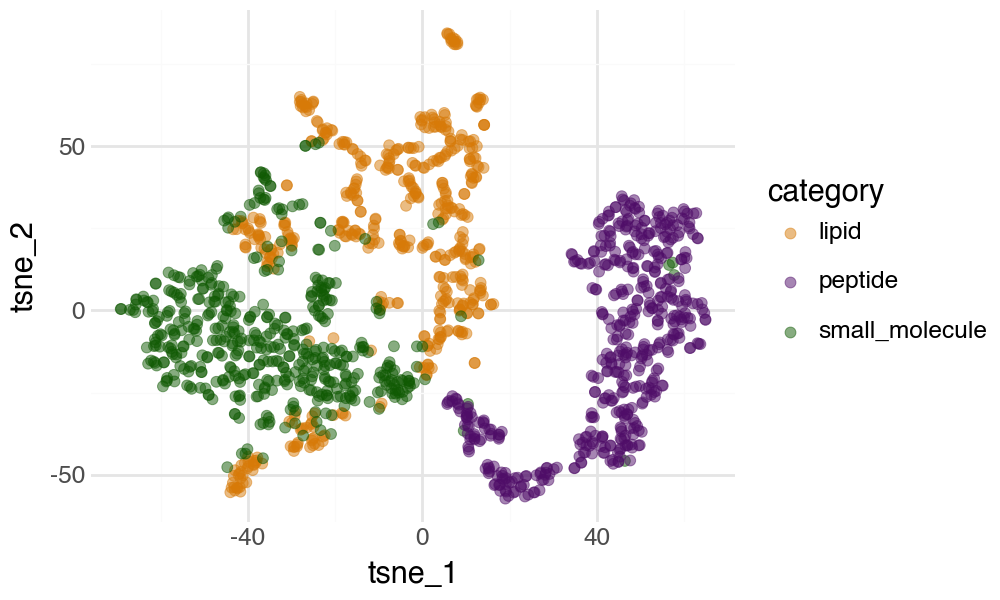

In [6]:
# calculate TSNE on embeddings matrix
tsne = TSNE(n_components=2, perplexity=10)
embeddings_2d = tsne.fit_transform(embeddings)

# add back to original data frame
df_mol_types['tsne_1'] = embeddings_2d[:,0]
df_mol_types['tsne_2'] = embeddings_2d[:,1]

# visualize
(pln.ggplot(df_mol_types, pln.aes(x='tsne_1', y='tsne_2', color='category'))
 + pln.geom_point(alpha=0.5, size=2, stroke=0.2)
 + pln.scale_color_manual(values=["#D77A08", "#4F0D68", "#105A03"])
 + pln.theme_minimal()
 + pln.theme(figure_size=(5, 3))
)

Finally, we train a RandomForest classifier to predict molecule type.

In [7]:
# train a simple classifier on the embeddings to predict category
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, df_mol_types['category'], test_size=0.2
)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

                precision    recall  f1-score   support

         lipid       0.98      0.99      0.99       100
       peptide       0.99      1.00      0.99        94
small_molecule       0.99      0.97      0.98       106

      accuracy                           0.99       300
     macro avg       0.99      0.99      0.99       300
  weighted avg       0.99      0.99      0.99       300



The classifier is highly accurate.

Let's visualize the predicted molecule types and the incorrect predictions. First we create a new data frame with only test data and with information about model predictions.

In [8]:
df_mol_types_test = df_mol_types.iloc[y_test.index].copy()
df_mol_types_test['correct'] = (y_test == y_pred).values
df_mol_types_test['predicted_category'] = y_pred

Now we can generate the plot. We create two panels. The first shows the predicted categories, and the second shows which data points are predicted correctly and which are wrong.

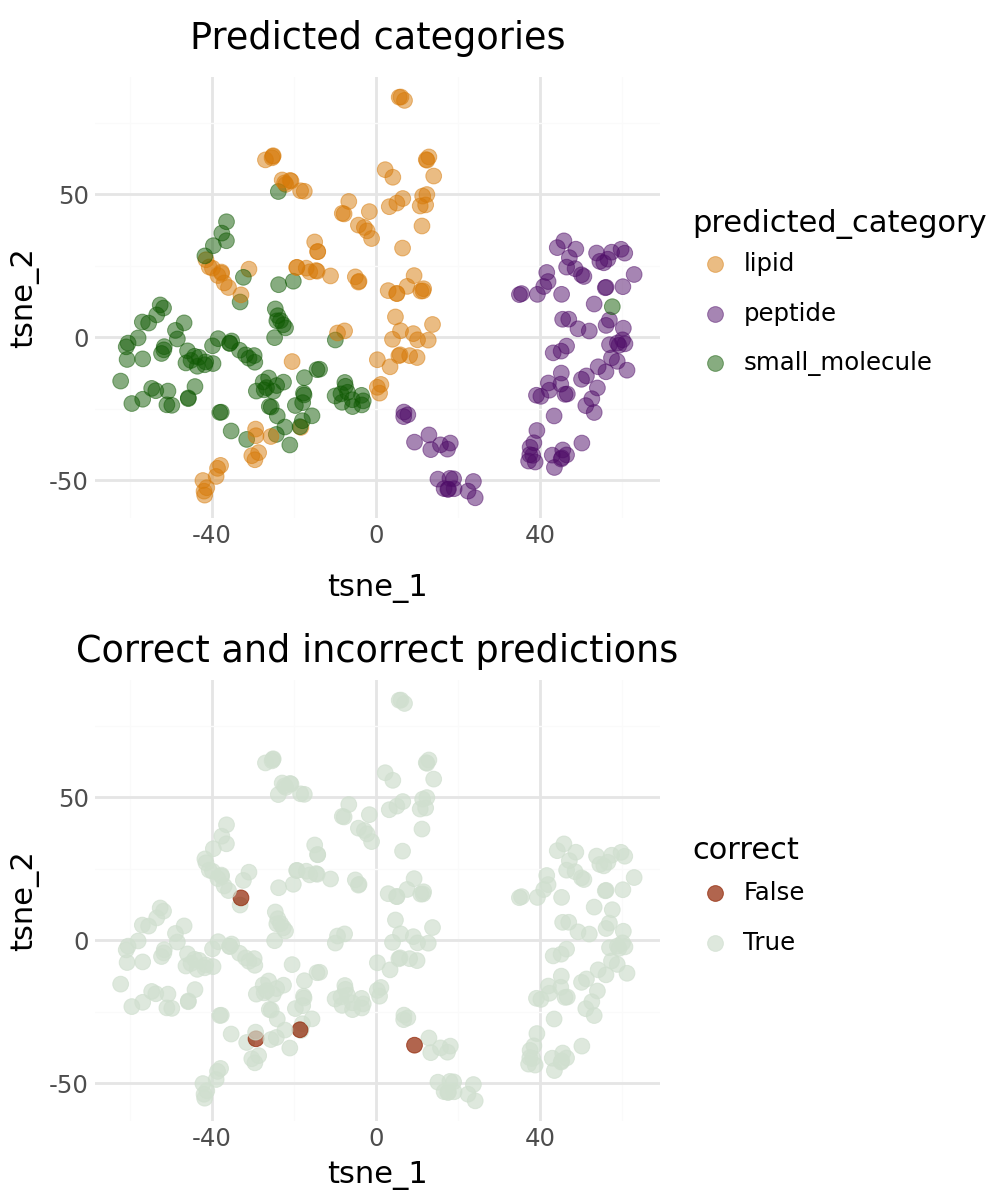

In [9]:
plot_pred = (pln.ggplot(df_mol_types_test, pln.aes(x='tsne_1', y='tsne_2', color='predicted_category'))
 + pln.geom_point(alpha=0.5, size=3, stroke=0.2)
 + pln.scale_color_manual(values=["#D77A08", "#4F0D68", "#105A03"])
 + pln.theme_minimal()
 + pln.labs(title = "Predicted categories")
 + pln.theme(figure_size=(5, 3))
)

plot_acc = (pln.ggplot(df_mol_types_test, pln.aes(x='tsne_1', y='tsne_2', color='correct'))
 + pln.geom_point(alpha=0.7, size=3, stroke=0.2)
 + pln.scale_color_manual(values=["#902302", "#D0DFCF"])
 + pln.theme_minimal()
 + pln.labs(title = "Correct and incorrect predictions")
 + pln.theme(figure_size=(5, 3))
)

(plot_pred / plot_acc) + pln.theme(figure_size =(5, 6))

Calculate a confusion matrix. In the returned matrix, columns are predicted and rows are true values. (See [here.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html))

In [10]:
conf_mat = confusion_matrix(y_test, y_pred, labels=df_mol_types['category'].unique())
conf_mat

array([[ 99,   1,   0],
       [  2, 103,   1],
       [  0,   0,  94]])

Now we can plot.

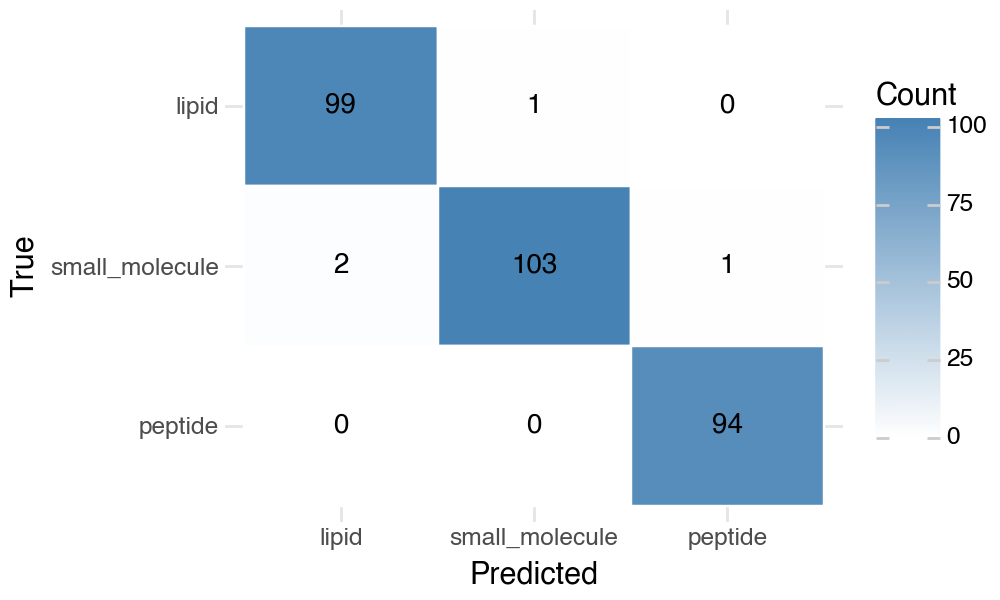

In [11]:
# reshape confusion matrix to long format
categories = df_mol_types['category'].unique()
conf_df = pd.DataFrame(conf_mat, index=categories, columns=categories)
conf_df_long = conf_df.reset_index().melt(id_vars='index')
conf_df_long.columns = ['True', 'Predicted', 'Count']

# and plot
(pln.ggplot(conf_df_long, pln.aes(x='Predicted', y='True', fill='Count'))
 + pln.geom_tile(color='white', size=0.5)
 + pln.geom_text(pln.aes(label='Count'), color='black', size=10)
 + pln.scale_fill_gradient(low='white', high='steelblue')
 + pln.scale_x_discrete(limits=list(categories)) 
 + pln.scale_y_discrete(limits=list(categories[::-1])) # reverse y axis to get diagonal from top left to bottom right
 + pln.theme_minimal()
 + pln.theme(figure_size=(5, 3))
)

## Part 2: Predict membrane permeation

Now we will train a predictor of membrane permeation, similar to what was done in [Feller & Wilke (2025).](https://doi.org/10.1021/acs.jcim.4c01441) We are not fine-tuning the model, however, we are simply fitting a Random Forest regression model.

The data file holds the SMILES string for each molecule and the associated PAMPA (membrane permeation) score. The molecules have already been clustered, and the data file also lists the cluster ID (an integer between 1 and 6).

In [12]:
df_cycpept_full = pd.read_csv("data/PAMPA-clustered.csv")
df_cycpept_full

,SMILES,PAMPA,cluster
0,CCCN1CC(=O)N(C)[C@@H](CC(C)C)C(=O)N(Cc2ccccc2)...,-5.13,1
1,CC(C)C[C@H]1C(=O)N[C@@H](Cc2ccccc2)C(=O)N2CCC[...,-5.63,1
2,CCCN1CC(=O)N[C@@H](CC(C)C)C(=O)N(Cc2ccccc2)CC(...,-5.75,1
3,CC(C)C[C@H]1C(=O)N(Cc2ccccc2)CC(=O)N2CCC[C@H]2...,-5.26,1
4,CCCN1CC(=O)N(C)[C@@H](CC(C)C)C(=O)N(C)[C@H](CC...,-4.78,1
...,...,...,...
6696,CC(C)C[C@@H]1NC(=O)[C@H](CO)N(C)C(=O)C[C@@H](C...,-4.62,6
6697,CC[C@H](C)[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@H](...,-5.60,6
6698,CC[C@H](C)[C@@H]1NC(=O)[C@H](C)N(C)C(=O)[C@H](...,-4.51,6
6699,CC(C)C[C@@H]1NC(=O)[C@H](Cc2ccccc2)N(C)C(=O)[C...,-6.90,6


Let's randomly pick 20% of this data frame to make downstream computations faster.

In [13]:
sample_frac = 0.2 # use a different fraction if you want
seed = 2834956

df_cycpept = (df_cycpept_full
    .groupby('cluster', group_keys=False)
    .sample(frac=sample_frac, random_state=seed)
)
df_cycpept

,SMILES,PAMPA,cluster
1284,CC(C)C[C@H]1C(=O)N[C@@H](Cc2ccccc2)CC(=O)N2CCC...,-5.23,1
1347,CCCCCN1CC(=O)N(C)[C@@H](CC(C)C)C(=O)N[C@@H](CC...,-4.94,1
455,CC(C)C[C@H]1C(=O)N[C@@H](Cc2ccccc2)C(=O)N2CCC[...,-6.09,1
476,CC(C)C[C@H]1C(=O)N[C@@H](Cc2ccccc2)C(=O)N2CCC[...,-5.11,1
1537,CCCN1CC(=O)N[C@H](CC(C)C)C(=O)N(Cc2ccccc2)CC(=...,-5.88,1
...,...,...,...
6463,CNC(=O)CC[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C...,-5.62,6
6344,CC[C@H](C)[C@@H]1NC(=O)CCCCCc2ccc(cc2)C[C@@H](...,-6.62,6
6503,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccccc2)NC(=O)[...,-4.34,6
6578,CC(C)C[C@@H]1NC(=O)[C@H](CC(C)C)N(C)C(=O)[C@H]...,-6.22,6


Now we calculate embeddings.

In [14]:
# list to store the embeddings
embeddings_cycpept = []

# important: keep SMILES in a list in the same order as df
smiles_list = df_cycpept["SMILES"].tolist()

batch_size = 64       # you can go up or down depending on VRAM
emb_list = []

dataloader = DataLoader(smiles_list, batch_size=batch_size, shuffle=False)

model.eval()
with torch.no_grad():
    for batch in tqdm(dataloader, total=len(dataloader)):
        # Tokenize batch of SMILES
        encoded = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)

        outputs = model(**encoded)
        pooled = outputs["mean_pool"]             # shape: (B, D)

        emb_list.append(pooled.cpu().numpy())     # append whole batch at once

# stack into a single array (N, D)
embeddings_cycpept = np.vstack(emb_list)

print(embeddings_cycpept.shape)

embeddings_cycpept

100%|██████████| 21/21 [00:05<00:00,  3.54it/s]

(1340, 512)


array([[-1.7703402e-04,  5.8187999e-02,  1.3572566e-01, ...,
         2.0892042e-01,  3.8758170e-02, -1.5437388e-02],
       [-3.8761493e-02,  2.1047128e-02,  1.3118353e-01, ...,
         9.2918210e-02,  4.5698700e-03, -9.4552778e-02],
       [-1.0297486e-02,  5.1149551e-02,  1.4106867e-01, ...,
         1.9103031e-01,  4.7222029e-02, -2.1052834e-02],
       ...,
       [-2.3866137e-02,  2.9371697e-02,  9.6248843e-02, ...,
         1.9907928e-01,  4.4745564e-02, -9.7833667e-03],
       [ 1.3843900e-01,  4.0810738e-02,  2.2232528e-01, ...,
         2.5907487e-01,  5.9055001e-02, -1.0363794e-01],
       [ 2.1128977e-02,  4.7847912e-02,  1.6203937e-01, ...,
         1.6033258e-01,  2.0964402e-03, -6.0316078e-02]],
      shape=(1340, 512), dtype=float32)

Next we train a Random Forest regressor. We do this repeatedly using each unique cluster once as the hold-out cluster for testing.

In [15]:
# define X and y for regression model to predict PAMPA permeability
X = embeddings_cycpept
y = df_cycpept

# columns are 'SMILES', 'PAMPA', and 'cluster'
y = df_cycpept['PAMPA'].values
clusters = df_cycpept['cluster'].values

# loop through all unique clusters and use one cluster as test set and rest as train set
predictions = []

unique_clusters = np.unique(clusters)
for test_cluster in tqdm(unique_clusters, total=len(unique_clusters)):
    train_indices = np.where(clusters != test_cluster)[0]
    test_indices = np.where(clusters == test_cluster)[0]
    
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    reg = RandomForestRegressor(n_estimators=100, n_jobs=40)
    reg.fit(X_train, y_train)
    y_pred_reg = reg.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred_reg)
    r2 = r2_score(y_test, y_pred_reg)
    spearman_corr, _ = spearmanr(y_test, y_pred_reg)

    print(f"Test Cluster: {test_cluster} | MSE: {mse} | R^2: {r2} | Spearman Correlation: {spearman_corr}")

    predictions.append((y_test, y_pred_reg))


 17%|█▋        | 1/6 [00:05<00:27,  5.45s/it]

Test Cluster: 1 | MSE: 0.41143310583415105 | R^2: -0.12401395178168073 | Spearman Correlation: 0.510008639031873


 33%|███▎      | 2/6 [00:11<00:22,  5.60s/it]

Test Cluster: 2 | MSE: 0.5221834965529007 | R^2: -0.14913686165905293 | Spearman Correlation: -0.16189163169578505


 50%|█████     | 3/6 [00:16<00:16,  5.54s/it]

Test Cluster: 3 | MSE: 0.5881916867697597 | R^2: 0.11088466443447276 | Spearman Correlation: 0.2814439130743105


 67%|██████▋   | 4/6 [00:22<00:11,  5.62s/it]

Test Cluster: 4 | MSE: 0.298541721967785 | R^2: 0.19664084036472107 | Spearman Correlation: 0.4742982295334554


 83%|████████▎ | 5/6 [00:29<00:06,  6.20s/it]

Test Cluster: 5 | MSE: 0.580927939742992 | R^2: 0.2133504042084856 | Spearman Correlation: 0.4968285492031601


100%|██████████| 6/6 [00:36<00:00,  6.06s/it]

Test Cluster: 6 | MSE: 0.9672626671745234 | R^2: 0.13092318572172246 | Spearman Correlation: 0.6046615585052129


Calculate overall model performance.

In [16]:
# calculate overall MSE, R2, and Spearman correlation
all_y_true = np.concatenate([y_true for y_true, y_pred in predictions])
all_y_pred = np.concatenate([y_pred for y_true, y_pred in predictions])

overall_mse = mean_squared_error(all_y_true, all_y_pred)
overall_r2 = r2_score(all_y_true, all_y_pred)
overall_spearman_corr, _ = spearmanr(all_y_true, all_y_pred)
# calculate accuracy for positive permeability (PAMPA > -5.5) vs negative permeability (PAMPA <= -5.5)
accuracy = np.mean((all_y_true > -5.5) == (all_y_pred > -5.5))

print(f"Overall MSE: {overall_mse}\nOverall R^2: {overall_r2}\nOverall Spearman Correlation: {overall_spearman_corr}\nOverall Accuracy: {accuracy}")

Overall MSE: 0.5083307639102738
Overall R^2: 0.15397318699754525
Overall Spearman Correlation: 0.37362874173658883
Overall Accuracy: 0.6649253731343283


Plot predicted versus true permeability for each cluster.

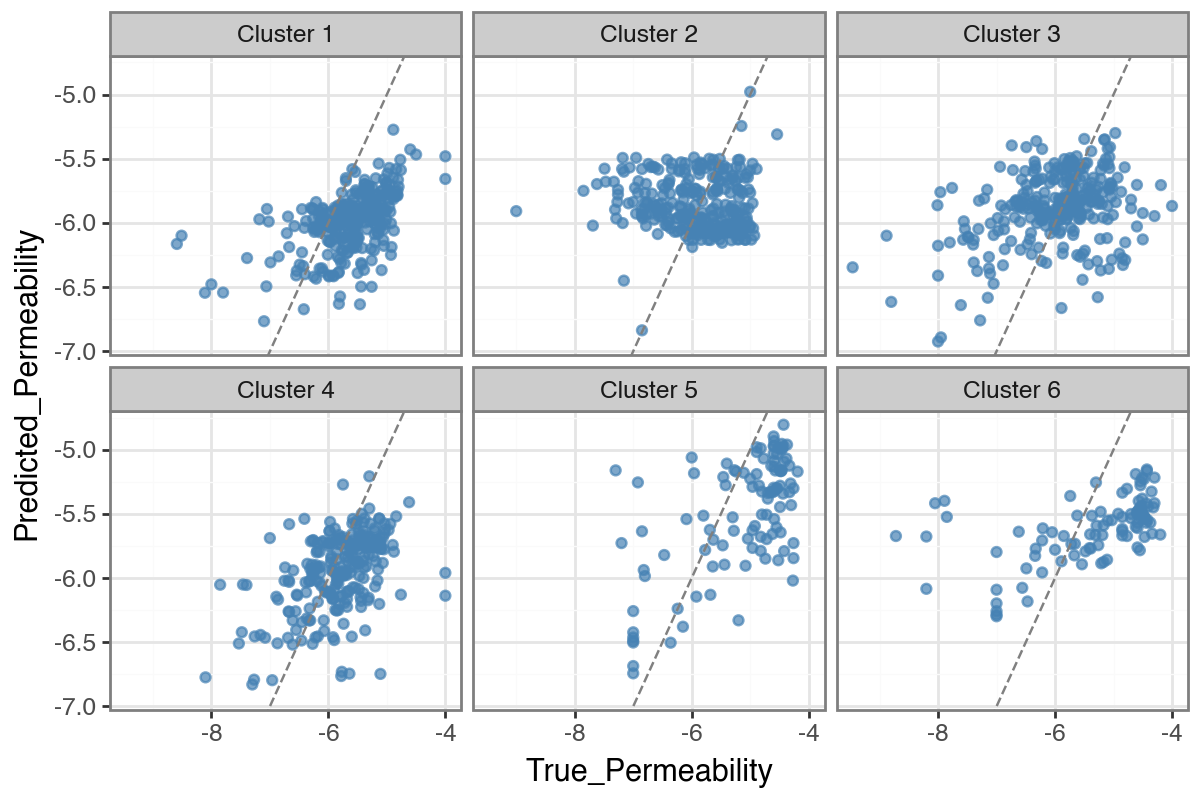

In [17]:
# prepare data for plotting
plot_data = []
for i, (y_true, y_pred) in enumerate(predictions):
    for true_val, pred_val in zip(y_true, y_pred):
        plot_data.append({
            'True_Permeability': true_val,
            'Predicted_Permeability': pred_val,
            'Test_Cluster': f'Cluster {unique_clusters[i]}'
        })

plot_df = pd.DataFrame(plot_data)

# create plot
(pln.ggplot(plot_df, pln.aes(x='True_Permeability', y='Predicted_Permeability'))
 + pln.geom_point(alpha=0.7, color='steelblue')
 + pln.geom_abline(intercept=0, slope=1, linetype='dashed', color='grey')
 + pln.facet_wrap('~Test_Cluster', ncol=3)
 + pln.theme_bw()
 + pln.theme(figure_size=(6, 4))
)

Repeat everything one more time with suffled clusters, for comparison. This shows how critical it is to cluster data to avoid data leakage from training to test.

In [18]:
# define X and y for regression model to predict PAMPA permeability
X = embeddings_cycpept
y = df_cycpept

# columns are 'SMILES', 'PAMPA', and 'cluster'
y = df_cycpept['PAMPA'].values
clusters = df_cycpept['cluster'].values

# shuffle clusters
perm = np.random.permutation(len(clusters))
clusters = clusters[perm]

# loop through all unique clusters and use one cluster as test set and rest as train set
predictions = []

unique_clusters = np.unique(clusters)
for test_cluster in tqdm(unique_clusters, total=len(unique_clusters)):
    train_indices = np.where(clusters != test_cluster)[0]
    test_indices = np.where(clusters == test_cluster)[0]
    
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    reg = RandomForestRegressor(n_estimators=100, n_jobs=40)
    reg.fit(X_train, y_train)
    y_pred_reg = reg.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred_reg)
    r2 = r2_score(y_test, y_pred_reg)
    spearman_corr, _ = spearmanr(y_test, y_pred_reg)

    print(f"Test Cluster: {test_cluster} | MSE: {mse} | R^2: {r2} | Spearman Correlation: {spearman_corr}")

    predictions.append((y_test, y_pred_reg))


 17%|█▋        | 1/6 [00:05<00:28,  5.76s/it]

Test Cluster: 1 | MSE: 0.32552361236335836 | R^2: 0.4354967224427222 | Spearman Correlation: 0.6705236572508474


 33%|███▎      | 2/6 [00:11<00:23,  5.99s/it]

Test Cluster: 2 | MSE: 0.27227489477815686 | R^2: 0.48201936777026266 | Spearman Correlation: 0.6551048486956207


 50%|█████     | 3/6 [00:18<00:18,  6.07s/it]

Test Cluster: 3 | MSE: 0.3406488738660367 | R^2: 0.46408537998876287 | Spearman Correlation: 0.6698894994356387


 67%|██████▋   | 4/6 [00:24<00:12,  6.30s/it]

Test Cluster: 4 | MSE: 0.304592003319502 | R^2: 0.5458095574985607 | Spearman Correlation: 0.7297301068268645


 83%|████████▎ | 5/6 [00:32<00:06,  6.75s/it]

Test Cluster: 5 | MSE: 0.3678915337094034 | R^2: 0.4432820937401789 | Spearman Correlation: 0.6141019500877064


100%|██████████| 6/6 [00:39<00:00,  6.63s/it]

Test Cluster: 6 | MSE: 0.34685155615600377 | R^2: 0.34261049122126386 | Spearman Correlation: 0.5936520123331198


Overall model performance and plot.

Overall MSE: 0.3183593534713768
Overall R^2: 0.4701470610689763
Overall Spearman Correlation: 0.667931768434786
Overall Accuracy: 0.7522388059701492


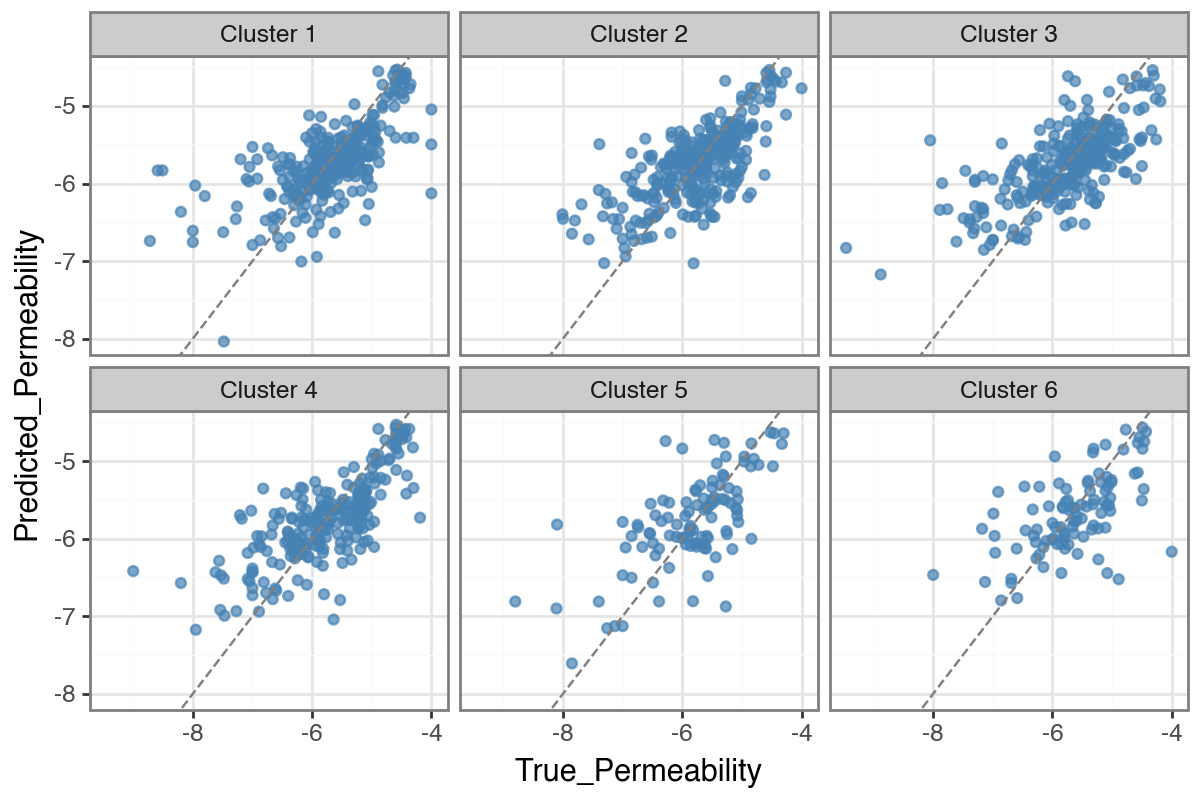

In [19]:
# calculate overall MSE, R2, and Spearman correlation
all_y_true = np.concatenate([y_true for y_true, y_pred in predictions])
all_y_pred = np.concatenate([y_pred for y_true, y_pred in predictions])

overall_mse = mean_squared_error(all_y_true, all_y_pred)
overall_r2 = r2_score(all_y_true, all_y_pred)
overall_spearman_corr, _ = spearmanr(all_y_true, all_y_pred)
# calculate accuracy for positive permeability (PAMPA > -5.5) vs negative permeability (PAMPA <= -5.5)
accuracy = np.mean((all_y_true > -5.5) == (all_y_pred > -5.5))

print(f"Overall MSE: {overall_mse}\nOverall R^2: {overall_r2}\nOverall Spearman Correlation: {overall_spearman_corr}\nOverall Accuracy: {accuracy}")

# prepare data for plotting
plot_data = []
for i, (y_true, y_pred) in enumerate(predictions):
    for true_val, pred_val in zip(y_true, y_pred):
        plot_data.append({
            'True_Permeability': true_val,
            'Predicted_Permeability': pred_val,
            'Test_Cluster': f'Cluster {unique_clusters[i]}'
        })

plot_df = pd.DataFrame(plot_data)

# create plot
(pln.ggplot(plot_df, pln.aes(x='True_Permeability', y='Predicted_Permeability'))
 + pln.geom_point(alpha=0.7, color='steelblue')
 + pln.geom_abline(intercept=0, slope=1, linetype='dashed', color='grey')
 + pln.facet_wrap('~Test_Cluster', ncol=3)
 + pln.theme_bw()
 + pln.theme(figure_size=(6, 4))
)


## Exercises

- In Part 1, subset the data so you have unbalanced numbers of molecule types and see how it changes predictor performance and behavior.

- In Part 2, re-do the PAMPA predictions without down-sampling the data.

 